## Getting ready
Import important modules and dataset

In [1]:
import tensorflow as tf 
#import tensorflow.compat.v1 as tf # For running intel GPU xD 
import matplotlib.pyplot as plt
import numpy as np

data_raw = tf.keras.datasets.cifar10

Seperate data into testing & training data

In [2]:
(x_train, y_train), (x_test, y_test) = data_raw.load_data()

Modify the labels to reflect the expected outcome (either car or not a car)

In [3]:
class_names = ['Not a car', 'Automobile/Car']

for i in range(y_train.shape[0]):
    if y_train[i][0] not in {1, 9}:
        y_train[i][0] = 0
    else:
        y_train[i][0] = 1
        
for i in range(y_test.shape[0]):
    if y_test[i][0] not in {1, 9}:
        y_test[i][0] = 0
    else:
        y_test[i][0] = 1

## Normalize the data
This scales the color values of each pixel, which is more appropriate than standardizing.

In [4]:
x_train_min = np.min(x_train)
x_train_max = np.max(x_train)
x_train_normal = (x_train - x_train_min) / (x_train_max - x_train_min)
x_test_normal = (x_test - x_train_min) / (x_train_max - x_train_min)
x_train, x_test = x_train / 255.0, x_test / 255.0

'Flatten' the images so they are represented by a 1d array
* This is only used for some models

In [5]:
x_train_flat = x_train_normal.reshape(x_train_normal.shape[0], -1)
x_test_flat = x_test_normal.reshape(x_test_normal.shape[0], -1)

# Building the Models
Models are generated from classes so it's easier to tweak parameters later and manage variable names

In [6]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from functools import partial

class UniformDeepDense:
    def __init__(self):
        self.model = models.Sequential(name="Normal")
        self.activation = 'relu'
        self.train_epochs = 40 # Diminishing returns past 10 epochs
        self.shape = (3072, ) # 32 x 32 x 3 (flattened)
        self.optimizer = Adam()
        self.generateLayers()
        self.compileModel()
    def generateLayers(self):
        self.model.add(layers.Dense(512, activation=self.activation, input_shape=self.shape))
        self.model.add(layers.Dense(256, activation=self.activation))
        self.model.add(layers.Dense(128, activation=self.activation))
        self.model.add(layers.Dense(2, activation='softmax'))
    def compileModel(self):
        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    def train(self, x_train, y_train, x_test, y_test):
        self.history = self.model.fit(x_train, y_train, epochs=self.train_epochs, validation_data=(x_test, y_test))
        self.loss, self.accuracy = self.model.evaluate(x_test, y_test)
        
class ConvNN:
    def __init__(self):
        self.model = models.Sequential(name="Convolutional")
        self.shape=[32, 32, 3] # Conv2D needs list
        self.epochs = 40
        self.optimizer = Adam()
        self.default_layer = partial(layers.Conv2D, kernel_size=3,
                                    padding='same', activation='relu',
                                    kernel_initializer='he_normal')
        self.generateLayers()
        self.compile_model()
    def generateLayers(self):
        self.model.add(self.default_layer(filters=64, kernel_size=7, input_shape=self.shape))
        self.model.add(layers.MaxPool2D())
        self.model.add(self.default_layer(filters=128))
        self.model.add(layers.MaxPool2D())
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(units=2, activation='softmax'))
    def compile_model(self):
        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    def train(self, x_train, y_train, x_test, y_test):
        self.history = self.model.fit(x_train, y_train, epochs=self.epochs, validation_data=(x_test, y_test))
        self.loss, self.accuracy = self.model.evaluate(x_test, y_test)
        


# Testing the models

In [7]:
normal_NN = UniformDeepDense()
normal_NN.train(x_train_flat, y_train, x_test_flat, y_test)

conv_NN = ConvNN()
conv_NN.train(x_train, y_train, x_test, y_test)

print(f"Normal NN loss: {normal_NN.loss}")
print(f"Normal NN Accuracy: {normal_NN.accuracy}")

print(f"Convolutional NN loss: {conv_NN.loss}")
print(f"Convolutional NN Accuracy: {conv_NN.accuracy}")

c:\Users\anrme\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.8229 - loss: 0.4177 - val_accuracy: 0.8651 - val_loss: 0.3360
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.8620 - loss: 0.3271 - val_accuracy: 0.8636 - val_loss: 0.3158
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.8698 - loss: 0.3121 - val_accuracy: 0.8784 - val_loss: 0.3078
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.8739 - loss: 0.3003 - val_accuracy: 0.8830 - val_loss: 0.2864
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.8792 - loss: 0.2898 - val_accuracy: 0.8879 - val_loss: 0.2804
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.8847 - loss: 0.2772 - val_accuracy: 0.8885 - val_loss: 0.2765
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.8860 - loss: 0.2730 - val_accuracy: 0.8899 - val_loss: 0.2675
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.8942 -

c:\Users\anrme\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 35ms/step - accuracy: 0.8727 - loss: 0.3446 - val_accuracy: 0.9337 - val_loss: 0.1663
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.9288 - loss: 0.1884 - val_accuracy: 0.9398 - val_loss: 0.1619
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 39ms/step - accuracy: 0.9397 - loss: 0.1618 - val_accuracy: 0.9405 - val_loss: 0.1581
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 39ms/step - accuracy: 0.9475 - loss: 0.1392 - val_accuracy: 0.9510 - val_loss: 0.1326
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.9550 - loss: 0.1236 - val_accuracy: 0.9528 - val_loss: 0.1265
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 50ms/step - accuracy: 0.9593 - loss: 0.1061 - val_accuracy: 0.9519 - val_loss: 0.1329
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.9648 - loss: 0.0946 - val_accuracy: 0.9514 - val_loss: 0.1346
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - accuracy: 0.9688 -

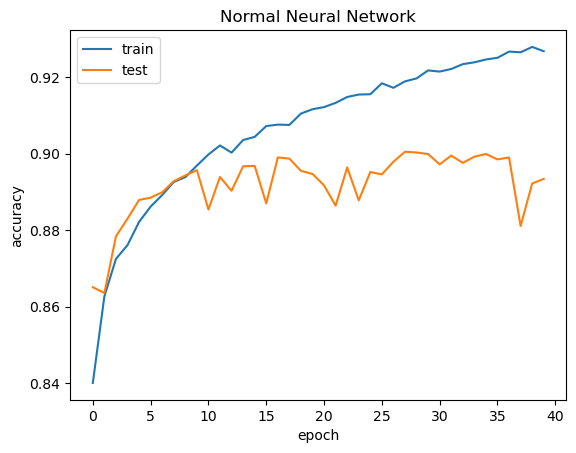

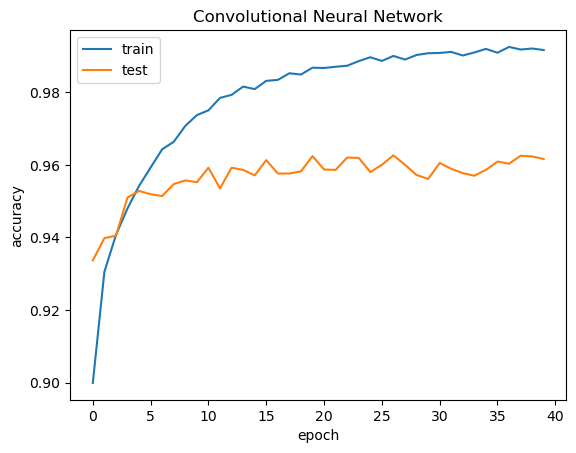

In [8]:
plt.plot(normal_NN.history.history['accuracy'])
plt.plot(normal_NN.history.history['val_accuracy'])
plt.title('Normal Neural Network')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(conv_NN.history.history['accuracy'])
plt.plot(conv_NN.history.history['val_accuracy'])
plt.title('Convolutional Neural Network')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()